In [9]:
# Clone your group repo (if not already)
!git clone https://github.com/dhyyunn/DSA4213-group-project-travel-assistant-chatbot.git
%cd DSA4213-group-project-travel-assistant-chatbot

# Create and switch to a new branch for baseline testing
!git checkout -b baseline-llama3.3

fatal: destination path 'DSA4213-group-project-travel-assistant-chatbot' already exists and is not an empty directory.
/content/DSA4213-group-project-travel-assistant-chatbot
fatal: A branch named 'baseline-llama3.3' already exists.


In [4]:
!pip install -q transformers accelerate bitsandbytes sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 MB 14.3 MB/s eta 0:00:00


In [10]:
!pwd


/content/DSA4213-group-project-travel-assistant-chatbot


In [6]:
!pip install jsonlines

In [1]:
from huggingface_hub import login
login(new_session=False)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [10]:
!pip install -U bitsandbytes
!pip install -U transformers accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.8/375.8 kB 22.4 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 1.10.1
    Uninstalling accelerate-1.10.1:
      Successfully uninstalled accelerate-1.10.1


In [2]:
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    pipeline,
)

model_name = "meta-llama/Llama-3.2-3b-instruct"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype="float16",
)

tokenizer = AutoTokenizer.from_pretrained(model_name, use_auth_token=True)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    torch_dtype="auto",
    quantization_config=bnb_config,
    use_auth_token=True,
)

generator = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=300,
    temperature=0.7,
    top_p=0.9,
)

/usr/local/lib/python3.12/dist-packages/transformers/models/auto/tokenization_auto.py:1025: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/transformers/models/auto/auto_factory.py:492: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

Device set to use cuda:0


In [11]:
import pandas as pd

df = pd.read_csv("data/evaluation_queries.csv")
print("Loaded", len(df), "queries")
df.head()

Loaded 10 queries


,query,expected_answer
0,What is the baggage allowance for Singapore Ai...,Economy passengers may check in up to 25 kg of...
1,How can I get from Changi Airport to the city ...,Changi Airport is connected to downtown Singap...
2,Is tap water safe to drink in Tokyo?,"Yes, Japan’s tap water is safe to drink and me..."
3,When is the best time to visit Seoul?,Spring (April–June) and autumn (September–Nove...
4,What is the best way to get around Bangkok?,Bangkok offers multiple transport options incl...


In [12]:
def generate_answer(prompt):
    output = generator(prompt)[0]["generated_text"]
    return output.strip()

df["generated_answer"] = df["query"].apply(generate_answer)
df.head()

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


,query,expected_answer,generated_answer
0,What is the baggage allowance for Singapore Ai...,Economy passengers may check in up to 25 kg of...,What is the baggage allowance for Singapore Ai...
1,How can I get from Changi Airport to the city ...,Changi Airport is connected to downtown Singap...,How can I get from Changi Airport to the city ...
2,Is tap water safe to drink in Tokyo?,"Yes, Japan’s tap water is safe to drink and me...",Is tap water safe to drink in Tokyo? Tokyo has...
3,When is the best time to visit Seoul?,Spring (April–June) and autumn (September–Nove...,When is the best time to visit Seoul? The answ...
4,What is the best way to get around Bangkok?,Bangkok offers multiple transport options incl...,What is the best way to get around Bangkok? ge...


In [13]:
# test out performance of baseline model using BGE (a model to compute similarity score between expected answer and generated ones)
from sentence_transformers import SentenceTransformer, util

encoder = SentenceTransformer("BAAI/bge-large-en-v1.5")

def compute_similarity(a, b):
    ea = encoder.encode(a, convert_to_tensor=True)
    eb = encoder.encode(b, convert_to_tensor=True)
    return float(util.cos_sim(ea, eb))

df["similarity"] = df.apply(
    lambda row: compute_similarity(row["generated_answer"], row["expected_answer"]),
    axis=1,
)

print("Average similarity:", df["similarity"].mean())

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/779 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

Average similarity: 0.7719076633453369


In [14]:
# save the results
output_path = "reports/evaluation_llama3.2_baseline.csv"
df.to_csv(output_path, index=False)
print(f"✅ Results saved to {output_path}")

✅ Results saved to reports/evaluation_llama3.2_baseline.csv


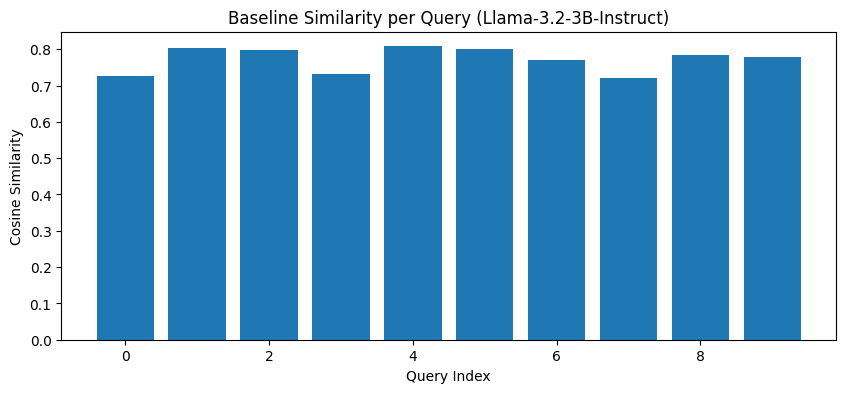

In [15]:
# visualise the result
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.bar(range(len(df)), df["similarity"])
plt.title("Baseline Similarity per Query (Llama-3.2-3B-Instruct)")
plt.xlabel("Query Index")
plt.ylabel("Cosine Similarity")
plt.show()

###Test out with RAG

In [16]:
#load data
import json, random

path = "data/wikivoyage_chunks.jsonl"

data = [json.loads(line) for line in open(path)]
print("Total entries:", len(data))

# sample 10 000 chunks for FAISS (balance quality vs. memory)
sampled_data = random.sample(data, 10_000)
corpus = [x["text"] for x in sampled_data]

Total entries: 207856


In [21]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 41.8 MB/s eta 0:00:00


In [22]:
# Build FAISS retrieval index
from sentence_transformers import SentenceTransformer
import numpy as np, faiss, torch

retriever = SentenceTransformer("BAAI/bge-large-en-v1.5")
embeddings = retriever.encode(corpus, convert_to_numpy=True, show_progress_bar=True)

index = faiss.IndexFlatL2(embeddings.shape[1])
index.add(np.array(embeddings, dtype="float32"))
print("✅ Indexed:", index.ntotal, "WikiVoyage chunks.")

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

✅ Indexed: 10000 WikiVoyage chunks.


In [23]:
# Using RAG-Lite(top-k,k=3)
def retrieve_context(query, top_k=3):
    q_emb = retriever.encode([query])
    D, I = index.search(np.array(q_emb, dtype="float32"), k=top_k)
    return [corpus[i] for i in I[0]]

def rag_answer(query):
    contexts = retrieve_context(query)
    context_text = "\n".join(contexts)
    prompt = (
        f"You are a helpful travel assistant. Use the information below to answer factually and concisely.\n\n"
        f"Context:\n{context_text}\n\nQuestion: {query}\nAnswer:"
    )
    result = generator(prompt)[0]["generated_text"]
    return result.strip(), contexts

In [24]:
# Test out with 1 example
query = "What can I do in 's-Hertogenbosch?"
answer, ctx = rag_answer(query)

print("🧭 Query:", query)
print("\n🔍 Retrieved Contexts:")
for c in ctx:
    print("-", c[:200].replace("\n", " "), "...")
print("\n💬 Model Answer:\n", answer)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


🧭 Query: What can I do in 's-Hertogenbosch?

🔍 Retrieved Contexts:
- mmer days, as it's a perfect day trip from any of those places.  Do Dress up and join the massive carnival celebrations that take over life in large parts of this region early in spring. It only lasts ...
- The never ending rebuilding of main roads also guarantees major daily traffic jams at the rush hours.  Get around The large majority of sights are within the old city fortifications. It's a compact ar ...
- a patronage and some farmes.  Tired of biking? Consider a relaxing day in the spa. The Thermen Geldrop are one of the best options around Eindhoven, and offers delightful saunas and massages as well a ...

💬 Model Answer:
 You are a helpful travel assistant. Use the information below to answer factually and concisely.

Context:
mmer days, as it's a perfect day trip from any of those places.

Do
Dress up and join the massive carnival celebrations that take over life in large parts of this region early in spring. 

In [25]:
# evaluate with evaluation_queries.csv
import pandas as pd
from sentence_transformers import util

df = pd.read_csv("data/evaluation_queries.csv")
results = []

for _, row in df.iterrows():
    q, ref = row["query"], row["expected_answer"]
    ans, _ = rag_answer(q)
    sim = util.cos_sim(
        retriever.encode(ans, convert_to_tensor=True),
        retriever.encode(ref, convert_to_tensor=True)
    ).item()
    results.append({"query": q, "answer": ans, "similarity": sim})

df_out = pd.DataFrame(results)
print("Average similarity:", df_out["similarity"].mean())

df_out.to_csv("reports/evaluation_llama3.2_RAG.csv", index=False)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Average similarity: 0.6882858633995056


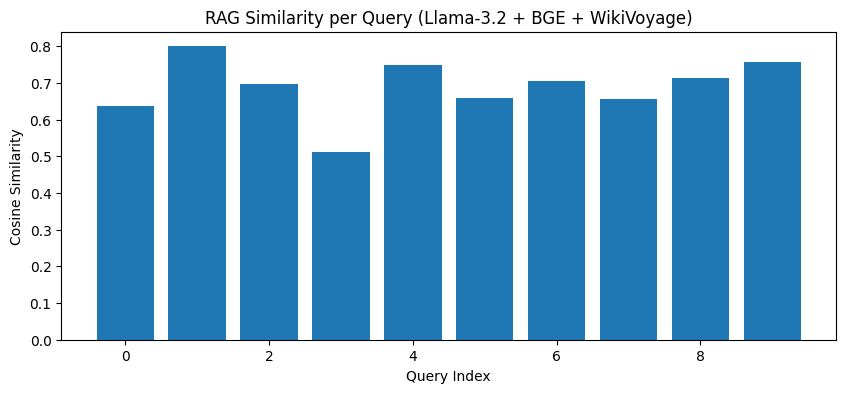

In [26]:
# visualise the improvement
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.bar(range(len(df_out)), df_out["similarity"])
plt.title("RAG Similarity per Query (Llama-3.2 + BGE + WikiVoyage)")
plt.xlabel("Query Index")
plt.ylabel("Cosine Similarity")
plt.show()

### Another RAG (rerank)

In [27]:
# RAG with reranker
# ============================================
# Reranker (improves context quality)
# ============================================
from sentence_transformers import CrossEncoder

# Load a compact reranker fine-tuned for MS MARCO relevance tasks
reranker = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2")

def retrieve_and_rerank(query, top_k=10, rerank_top=3):
    """
    1. Retrieve top_k passages via FAISS
    2. Rerank them using a cross-encoder
    3. Return top rerank_top passages
    """
    # --- Stage 1: FAISS dense retrieval ---
    q_emb = retriever.encode([query])
    D, I = index.search(np.array(q_emb, dtype="float32"), k=top_k)
    candidates = [corpus[i] for i in I[0]]

    # --- Stage 2: Reranking with CrossEncoder ---
    pairs = [(query, passage) for passage in candidates]
    scores = reranker.predict(pairs)

    reranked = sorted(zip(candidates, scores), key=lambda x: x[1], reverse=True)
    top_contexts = [text for text, _ in reranked[:rerank_top]]
    return top_contexts

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

In [28]:
def rag_reranked_answer(query):
    contexts = retrieve_and_rerank(query, top_k=10, rerank_top=3)
    context_text = "\n".join(contexts)
    prompt = (
        f"You are a helpful travel assistant. Use the information below to answer clearly and factually.\n\n"
        f"Context:\n{context_text}\n\nQuestion: {query}\nAnswer:"
    )
    result = generator(prompt)[0]["generated_text"]
    return result.strip(), contexts

In [29]:
results_reranked = []
for _, row in df.iterrows():
    q, ref = row["query"], row["expected_answer"]
    ans, _ = rag_reranked_answer(q)
    sim = util.cos_sim(
        retriever.encode(ans, convert_to_tensor=True),
        retriever.encode(ref, convert_to_tensor=True)
    ).item()
    results_reranked.append({"query": q, "answer": ans, "similarity": sim})

df_rerank = pd.DataFrame(results_reranked)
print("Average similarity (Reranked RAG):", df_rerank["similarity"].mean())

df_rerank.to_csv("reports/evaluation_llama3.2_RAG_reranked.csv", index=False)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Average similarity (Reranked RAG): 0.6705985009670258


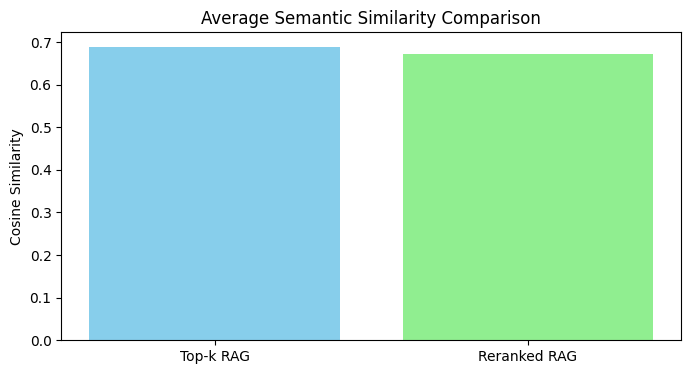

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.bar(["Top-k RAG", "Reranked RAG"],
        [df_out["similarity"].mean(), df_rerank["similarity"].mean()],
        color=["skyblue", "lightgreen"])
plt.title("Average Semantic Similarity Comparison")
plt.ylabel("Cosine Similarity")
plt.show()